# Import

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import Tuple, NoReturn
import seaborn as sns
import time


# Dataloader

In [2]:
#Transforms from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_dataset,validation_dataset = random_split(train_dataset,[round(0.9 * len(train_dataset)), round(0.1 * len(train_dataset))])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
BATCH_SIZE = 128
SHUFFLE = True
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=SHUFFLE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=SHUFFLE)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=SHUFFLE)


## Visualizing Data

In [4]:
cifar_label = {0:'airplane',
         1: 'automobile',
         2: 'bird',
         3: 'cat',
         4: 'deer',
         5: 'dog',
         6: 'frog',
         7: 'horse',
         8: 'ship',
         9: 'truck'}

/home/dhagash/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 128 + 1) instead
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow wit

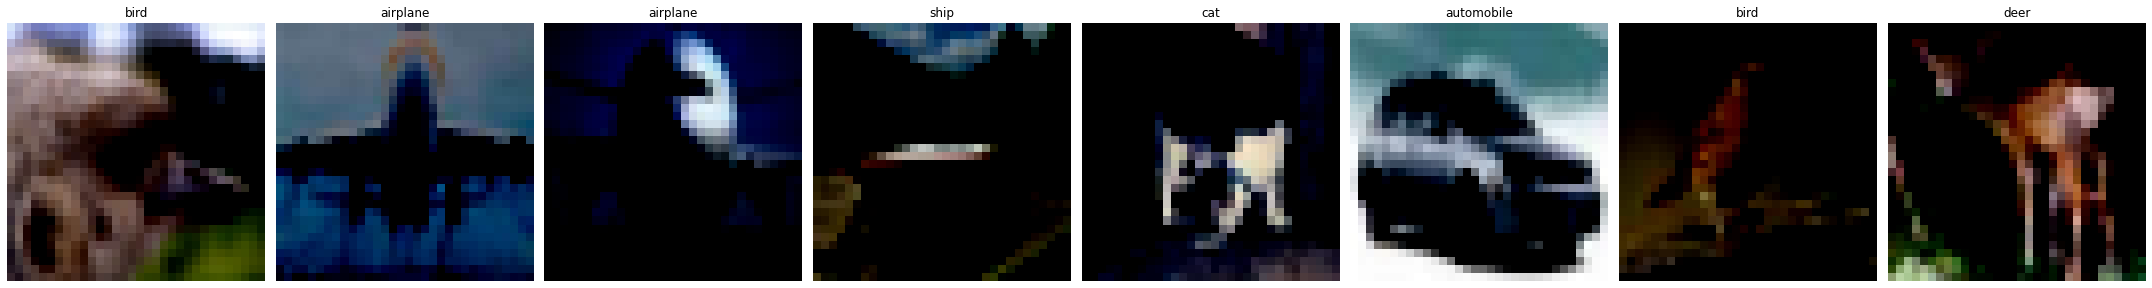

In [5]:
fig, ax = plt.subplots(1, 8)
fig.set_size_inches(30, 4)
datait = iter(train_loader)
for i in range(8):
    img, lbl = datait.next()
    idx = np.random.random_integers(0,img.shape[0])
    img_disp = img[idx].permute(1, 2, 0)
    ax[i].imshow(img_disp)
    ax[i].axis("off")
    ax[i].set_title(f"{cifar_label[lbl[idx].item()]}")

plt.tight_layout()
plt.show()


# Model

In [6]:
class SCNN(nn.Module):
    def __init__(self, activation: str, batch_norm: str, dropout: bool) -> None:
        super().__init__()

        #BASE MODEL
     
        #VGG Style architecture

        #Conv Block 1
        #(Nx3x32x32) -> (Nx32x16x16)
        conv1_1 = nn.Conv2d(in_channels=3, out_channels=32,
                          kernel_size=3, padding=1)
        conv1_2 = nn.Conv2d(in_channels=32, out_channels=32,
                          kernel_size=3, padding=1)
        pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Conv Block 2
        #(Nx32x16x16) -> (Nx64x8x8)
        conv2_1 = nn.Conv2d(in_channels=32, out_channels=64,
                            kernel_size=3, padding=1)
        conv2_2 = nn.Conv2d(in_channels=64, out_channels=64,
                            kernel_size=3, padding=1)
        pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Conv Block 3
        #(Nx64x8x8) -> (Nx128x4x4)
        conv3_1 = nn.Conv2d(in_channels=64, out_channels=128,
                            kernel_size=3, padding=1)
        conv3_2 = nn.Conv2d(in_channels=128, out_channels=128,
                            kernel_size=3, padding=1)
        pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        in_dim = 128*4*4
        fc1 = nn.Linear(in_dim,128)
        fc2 = nn.Linear(128,10)

        activation_layer = None
        dropout_layer = None
        if activation == 'relu':
            activation_layer = nn.ReLU()
        elif activation == 'lrelu':
            activation_layer = nn.LeakyReLU()
        else:
            if activation == 'elu':
                activation_layer = nn.ELU()


        self.conv_net = nn.Sequential(conv1_1,
                                      activation_layer,
                                      conv1_2,
                                      activation_layer,
                                      pool1,
                                      conv2_1,
                                      activation_layer,
                                      conv2_2,
                                      activation_layer,
                                      pool2,
                                      conv3_1,
                                      activation_layer,
                                      conv3_2,
                                      activation_layer,
                                      pool3,
                                      nn.Flatten(start_dim=1),
                                      fc1,
                                      fc2)

        if batch_norm == 'bnorm':
            bnorm1_1 = nn.BatchNorm2d(32)
            bnorm1_2 = nn.BatchNorm2d(32)
            bnorm2_1 = nn.BatchNorm2d(64)
            bnorm2_2 = nn.BatchNorm2d(64)
            bnorm3_1 = nn.BatchNorm2d(128)
            bnorm3_2 = nn.BatchNorm2d(128)

            self.conv_net = nn.Sequential(conv1_1,
                                          bnorm1_1,
                                          activation_layer,
                                          conv1_2,
                                          bnorm1_2,
                                          activation_layer,
                                          pool1,
                                          conv2_1,
                                          bnorm2_1,
                                          activation_layer,
                                          conv2_2,
                                          bnorm2_2,
                                          activation_layer,
                                          pool2,
                                          conv3_1,
                                          bnorm3_1,
                                          activation_layer,
                                          conv3_2,
                                          bnorm3_2,
                                          activation_layer,
                                          pool3,
                                          nn.Flatten(start_dim=1),
                                          fc1,
                                          activation_layer,
                                          fc2)
        elif batch_norm == 'gnorm':

            gnorm1_1 = nn.GroupNorm(8, 32)
            gnorm1_2 = nn.GroupNorm(8, 32)
            gnorm2_1 = nn.GroupNorm(8, 64)
            gnorm2_2 = nn.GroupNorm(8, 64)
            gnorm3_1 = nn.GroupNorm(8, 128)
            gnorm3_2 = nn.GroupNorm(8, 128)

            self.conv_net = nn.Sequential(conv1_1,
                                          gnorm1_1,
                                          activation_layer,
                                          conv1_2,
                                          gnorm1_2,
                                          activation_layer,
                                          pool1,
                                          conv2_1,
                                          gnorm2_1,
                                          activation_layer,
                                          conv2_2,
                                          gnorm2_2,
                                          activation_layer,
                                          pool2,
                                          conv3_1,
                                          gnorm3_1,
                                          activation_layer,
                                          conv3_2,
                                          gnorm3_2,
                                          activation_layer,
                                          pool3,
                                          nn.Flatten(start_dim=1),
                                          fc1,
                                          activation_layer,
                                          fc2)

        else:
            pass




        #############################################################################################
        #Add dropout in similar way, so one code for all
        ###############################################################################################

    def forward(self, x):
        
        
        y = self.conv_net(x)

        return y

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [7]:
cnn = SCNN(activation='elu',batch_norm='none',dropout=False)
params = count_model_params(cnn)
print(cnn)
print(f"Model has {params} learnable parameters")


SCNN(
  (conv_net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ELU(alpha=1.0)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ELU(alpha=1.0)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ELU(alpha=1.0)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ELU(alpha=1.0)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ELU(alpha=1.0)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=2048, out_features=128, bias=True)
    (17)

# Training

## Parameters for training

In [8]:
LR = 3e-4
EPOCHS = 50
EVAL_FREQ = 1
SAVE_FREQ = 10
val_acc = 0.0

In [9]:
stats = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "accuracy": []
}
init_epoch = 0

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = cnn.to(device)

In [11]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

In [12]:
@torch.no_grad()
def eval_model(model):
    correct = 0
    total = 0
    loss_list = []

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len(torch.where(preds == labels)[0])
        total += len(labels)

    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss


def save_model(model, optimizer, epoch, stats, val, time):
    """ Saving model checkpoint """
    if(not os.path.exists("models")):
        os.makedirs("models")
    if (val):

        savepath = f"models/best_val_{stats['model']}.pth"

        torch.save({
            'time': time,
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'stats': stats
        }, savepath)
        
    else:

        savepath = f"models/{stats['model']}_checkpoint_epoch_{epoch}.pth"

        torch.save({
            'time': time,
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'stats': stats
        }, savepath)

    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """

    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    time = checkpoint["time"]

    return model, optimizer, epoch, stats,time


def test_model(model):

    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len(torch.where(preds == labels)[0])
        total += len(labels)

    # Total correct predictions and loss
    accuracy = correct / total * 100
    
    return accuracy

In [13]:
loss_hist = []
stats['model'] = 'scnn_elu'
stats['parameters'] = params
start = time.perf_counter()
for epoch in range(EPOCHS):
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i,(images,labels) in progress_bar:

        loss_list = []

        x = images.to(device)
        y_train = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = cnn(x)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, y_train)

        # Getting gradients w.r.t. parameters
        loss.backward()
        loss_list.append(loss.item())

        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
    
    loss_hist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])
    

    if epoch % EVAL_FREQ == 0:
        accuracy, valid_loss = eval_model(cnn)
        print(f"Accuracy at epoch {epoch}: {round(accuracy, 2)}%")
    else:
        accuracy, valid_loss = -1, -1
    
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)


    #Saving best validation model
    if accuracy > val_acc:
        print(f"Best val model {epoch}")
        val_acc = accuracy
        save_model(model=cnn, optimizer=optimizer,
                   epoch=epoch, stats=stats, val=True, time = -1)


    if epoch % SAVE_FREQ == 0:
        save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats,val = False,time= -1)

end = time.perf_counter()
time = end - start
save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats, val=False, time= time)


Epoch 1 Iter 352: loss 1.30979. : 100%|██████████| 352/352 [00:04<00:00, 84.25it/s]


Accuracy at epoch 0: 52.86%
Best val model 0


Epoch 2 Iter 352: loss 1.06966. : 100%|██████████| 352/352 [00:03<00:00, 92.81it/s]


Accuracy at epoch 1: 61.54%
Best val model 1


Epoch 3 Iter 352: loss 0.88612. : 100%|██████████| 352/352 [00:03<00:00, 90.27it/s]


Accuracy at epoch 2: 67.2%
Best val model 2


Epoch 4 Iter 352: loss 1.28971. : 100%|██████████| 352/352 [00:04<00:00, 87.84it/s]


Accuracy at epoch 3: 69.1%
Best val model 3


Epoch 5 Iter 352: loss 0.57277. : 100%|██████████| 352/352 [00:03<00:00, 95.31it/s]


Accuracy at epoch 4: 72.06%
Best val model 4


Epoch 6 Iter 352: loss 0.79132. : 100%|██████████| 352/352 [00:03<00:00, 89.22it/s]


Accuracy at epoch 5: 72.56%
Best val model 5


Epoch 7 Iter 352: loss 0.78452. : 100%|██████████| 352/352 [00:03<00:00, 89.06it/s]


Accuracy at epoch 6: 73.88%
Best val model 6


Epoch 8 Iter 352: loss 0.43067. : 100%|██████████| 352/352 [00:03<00:00, 94.36it/s]


Accuracy at epoch 7: 75.54%
Best val model 7


Epoch 9 Iter 352: loss 0.54936. : 100%|██████████| 352/352 [00:03<00:00, 88.57it/s]


Accuracy at epoch 8: 75.8%
Best val model 8


Epoch 10 Iter 352: loss 0.44817. : 100%|██████████| 352/352 [00:03<00:00, 97.44it/s] 


Accuracy at epoch 9: 75.74%


Epoch 11 Iter 352: loss 0.32074. : 100%|██████████| 352/352 [00:03<00:00, 94.00it/s]


Accuracy at epoch 10: 75.7%


Epoch 12 Iter 352: loss 0.34366. : 100%|██████████| 352/352 [00:03<00:00, 94.34it/s]


Accuracy at epoch 11: 76.24%
Best val model 11


Epoch 13 Iter 352: loss 0.49488. : 100%|██████████| 352/352 [00:03<00:00, 94.79it/s]


Accuracy at epoch 12: 75.6%


Epoch 14 Iter 352: loss 0.39399. : 100%|██████████| 352/352 [00:03<00:00, 96.23it/s]


Accuracy at epoch 13: 76.74%
Best val model 13


Epoch 15 Iter 352: loss 0.20610. : 100%|██████████| 352/352 [00:03<00:00, 91.65it/s]


Accuracy at epoch 14: 76.04%


Epoch 16 Iter 352: loss 0.17233. : 100%|██████████| 352/352 [00:03<00:00, 94.83it/s]


Accuracy at epoch 15: 75.2%


Epoch 17 Iter 352: loss 0.08826. : 100%|██████████| 352/352 [00:03<00:00, 91.34it/s]


Accuracy at epoch 16: 75.84%


Epoch 18 Iter 352: loss 0.09536. : 100%|██████████| 352/352 [00:03<00:00, 95.19it/s]


Accuracy at epoch 17: 74.76%


Epoch 19 Iter 352: loss 0.28970. : 100%|██████████| 352/352 [00:03<00:00, 96.14it/s]


Accuracy at epoch 18: 75.28%


Epoch 20 Iter 352: loss 0.05257. : 100%|██████████| 352/352 [00:03<00:00, 95.17it/s]


Accuracy at epoch 19: 75.56%


Epoch 21 Iter 352: loss 0.02440. : 100%|██████████| 352/352 [00:03<00:00, 93.63it/s]


Accuracy at epoch 20: 75.6%


Epoch 22 Iter 352: loss 0.03108. : 100%|██████████| 352/352 [00:03<00:00, 95.46it/s]


Accuracy at epoch 21: 76.3%


Epoch 23 Iter 352: loss 0.11361. : 100%|██████████| 352/352 [00:03<00:00, 94.45it/s]


Accuracy at epoch 22: 75.46%


Epoch 24 Iter 352: loss 0.17053. : 100%|██████████| 352/352 [00:03<00:00, 93.59it/s]


Accuracy at epoch 23: 74.3%


Epoch 25 Iter 216: loss 0.06885. :  60%|█████▉    | 210/352 [00:02<00:01, 97.80it/s]

# Testing

In [ ]:
savepath = os.path.join(os.getcwd(), "models/", "best_val_scnn_elu.pth")


In [ ]:
cnn_test = SCNN(activation='elu',batch_norm='none',dropout=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_test = cnn_test.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

In [ ]:
model_elu,optimizer_elu,epoch_elu,stats_elu,time_elu = load_model(model=cnn_test,optimizer=optimizer,savepath=savepath)

In [ ]:
acc = test_model(model_elu)
print(acc)

75.61
49
208.49137637901003


# Comparision

## Training Time,Accuracy & Parameters

**Evaluated on best validation model exception time which is for 50 epochs**

$$
\begin{aligned}
& \text {Comparision of accuracy,parameters and training time of different models}\\
&\begin{array}{llccc}
\hline \text { Models } & \text {Activation} & \text {Accuracy} & \text {Training Time} & \text {Parameters}  \\
\hline \text {BaseModel}       & \text{ReLU}             & 73.06          & 302.558                & 550570   \\
\text{BaseModel}                      & \text{LeakyReLU} & 76.67          & 208.491                & 550570   \\
\text{BaseModel}                      & \text{ELU}       & 75.51          & 208.947                & 550570   \\ 
\text{BaseModel w/ Dropout}           & \text{ReLU}      & \textbf{81.84} & 1037.688               & 550570   \\
\text{BaseModel w/ Batch-Norm}        & \text{ReLU}      & 78.11          & \textbf{173.929}       & 551466   \\
\text{BaseModel w/ Group-Norm}        & \text{ReLU}      & 77.6           & 233.996                & 551466   \\
\hline
\end{array}
\end{aligned}
$$

- Droupout, Batch Norm are methods for reguralization and we can see improvement in accuracy
- Same behaviour is seen in activation as LeakyRelu and ELU improves over some disadvantages of ReLU improvement is seen in accuracy

## Generalization

- Plots for different training and validation loss
- 

# Activation Visualization

In [ ]:
savepath = os.path.join(os.getcwd(), "models", "best_val_scnn_relu.pth")
model,optimizer,epoch,stats= load_model(model=cnn,optimizer=optimizer,savepath=savepath)

FileNotFoundError: [Errno 2] No such file or directory: '/home/dhagash/MS-GE-03/CudaVision/assignment-3/models/best_val_scnn_relu.pth'

In [ ]:
#Code from https://discuss.pytorch.org/t/visualize-feature-map/29597/6 {PyTorch Forum}
# Visualize feature maps
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [ ]:
datait = iter(test_loader)

In [ ]:
images,labels = datait.next()


In [ ]:
#Code from https://discuss.pytorch.org/t/visualize-feature-map/29597/6 {PyTorch Forum}
activation = {}
model.conv_net[0].register_forward_hook(get_activation('activation_conv1_1'))
model.conv_net[2].register_forward_hook(get_activation('activation_conv1_2'))
model.conv_net[5].register_forward_hook(get_activation('activation_conv2_1'))
model.conv_net[7].register_forward_hook(get_activation('activation_conv2_2'))
model.conv_net[10].register_forward_hook(get_activation('activation_conv3_1'))
model.conv_net[12].register_forward_hook(get_activation('activation_conv3_2'))

output = model(images[0].unsqueeze(0).to(device))
# print(output.shape)




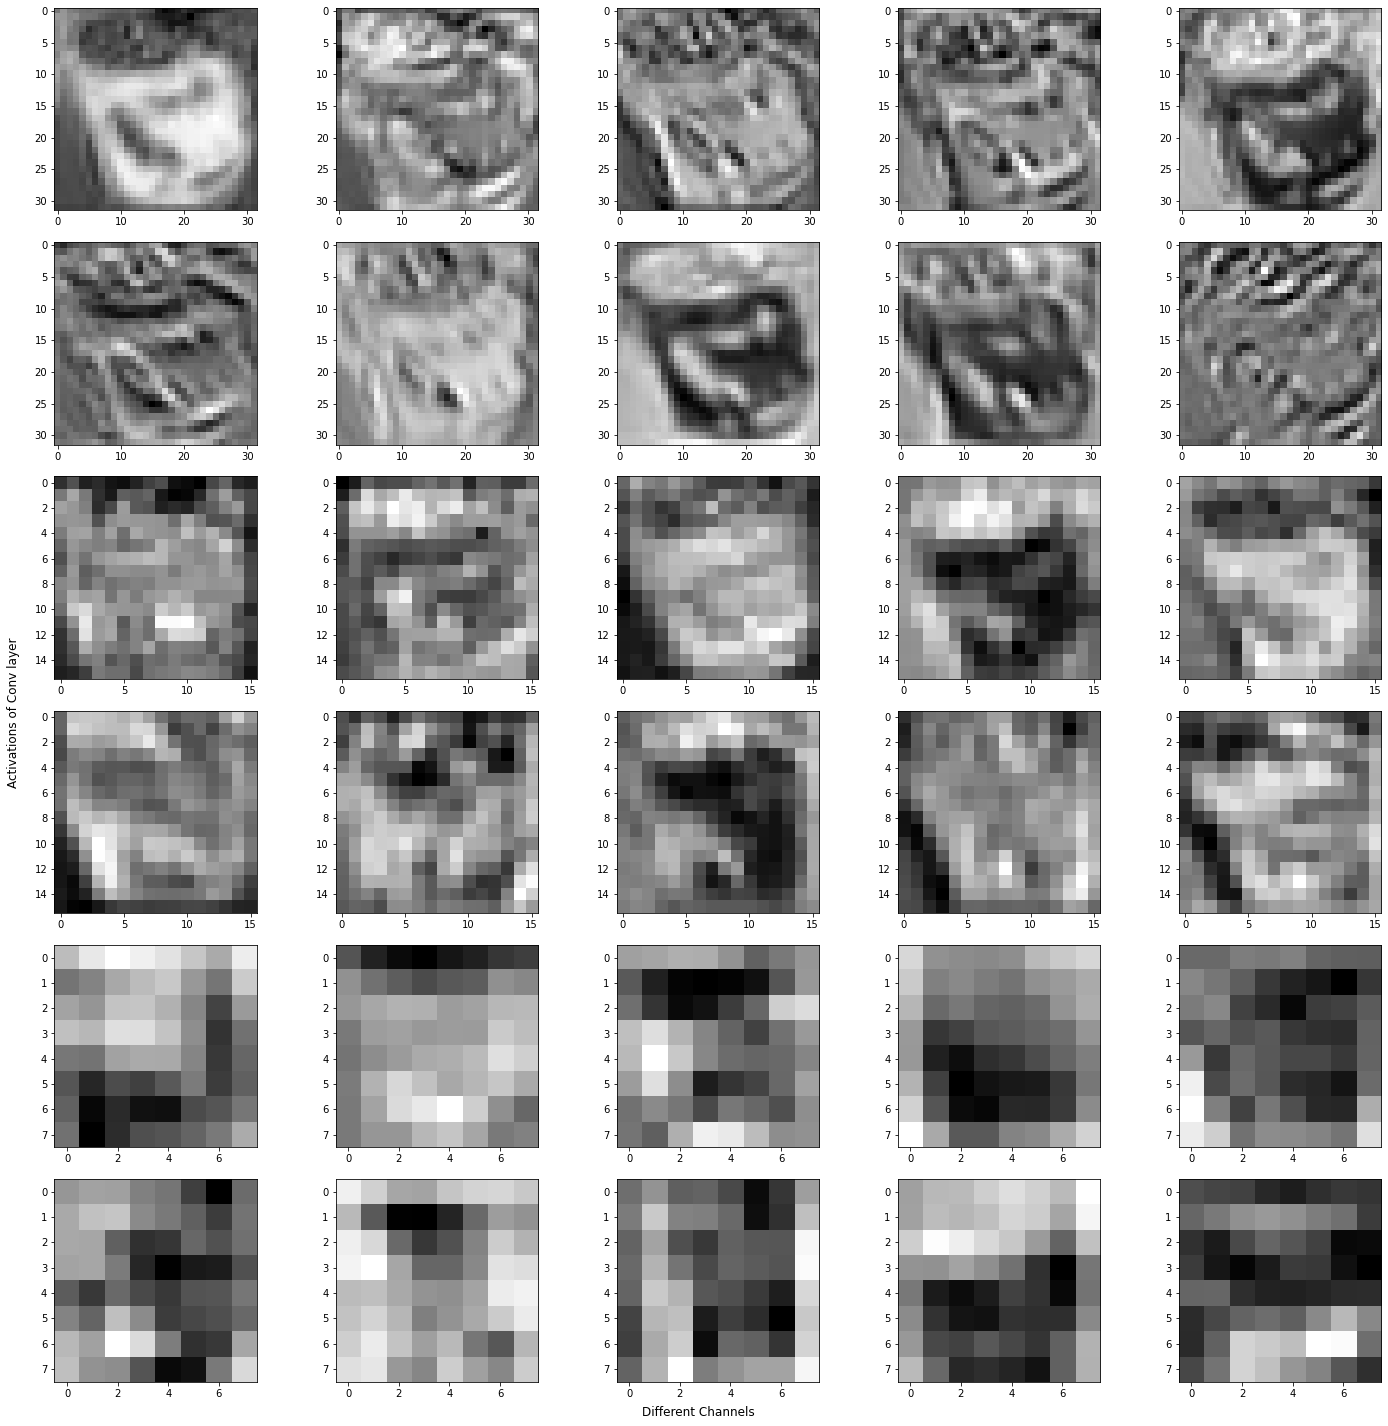

In [ ]:
num_plot = 5
fig, axarr = plt.subplots(6, num_plot, figsize=(20, 20))
fig.supxlabel('Different Channels')
fig.supylabel('Activations of Conv layer')
fig.tight_layout()

for cnt,(k, v) in zip(range(6),activation.items()):
    act = activation[k].squeeze()   
    for idx in range(num_plot):
        axarr[cnt,idx].imshow(act[idx].cpu().numpy(),cmap="gray")

- As seen in the lecture the initial layers will learn about edges and orientation which is quite visible in first two rows and then its learning complex structures which are hard to recognize

# Kernel Visualization 

In [ ]:
# https: // github.com/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb

def plot_rgb(weights):
   
    n_filters = 5
    fig,ax = plt.subplots(1,n_filters,figsize = (8,8))


    for i in range(n_filters):
        weight = weights[i]
        weight = weight - torch.min(weight)
        weight = weight / torch.max(weight)
        # weight.shape
       
        ax[i].imshow(weight.permute(1,2,0).cpu().numpy())
    plt.show()

def plot_single_channel(weights):

    n_filters = 5
    n_channels = 5
    fig, ax = plt.subplots(n_filters, n_channels,figsize=(8, 8))

    for i in  range(n_filters):
        for j in range(n_channels):
            # print(i,j)
            weight = weights[i,j]
            weight = weight - torch.min(weight)
            weight = weight / torch.max(weight)

            ax[i,j].imshow(weight.cpu().numpy())
            ax[i, j].axis('off')
            ax[i, j].set_title(str(i)+str(j))
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
    
    # plt.tight_layout()
    plt.show()


In [ ]:
def plot_weights(model,layer_num):

    layer = model.conv_net[layer_num]
    print(layer)
    
    if isinstance(layer,nn.Conv2d):
        weight_tensor = layer.weight.data.detach()
 
        if weight_tensor.shape[1] == 3:
            plot_rgb(weight_tensor)
        else:
            
            plot_single_channel(weight_tensor)



Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


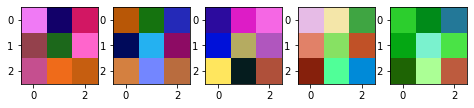

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


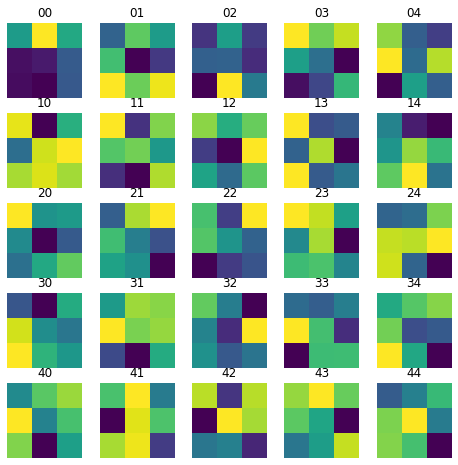

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


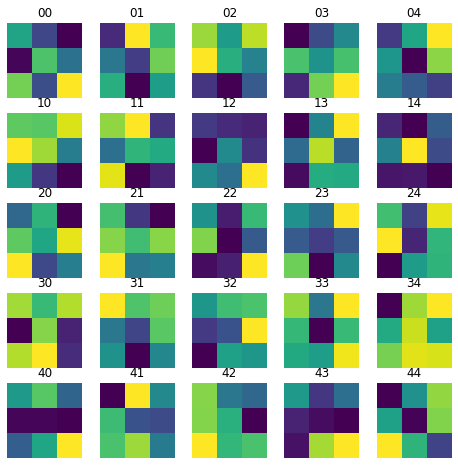

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


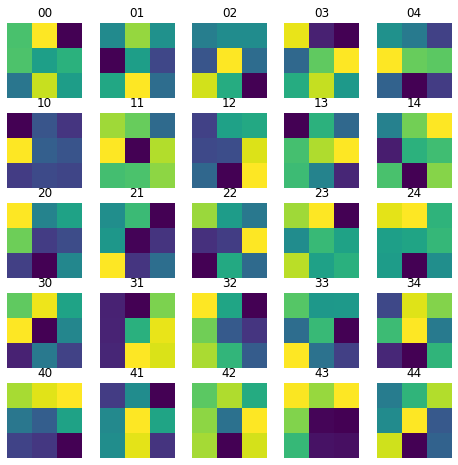

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


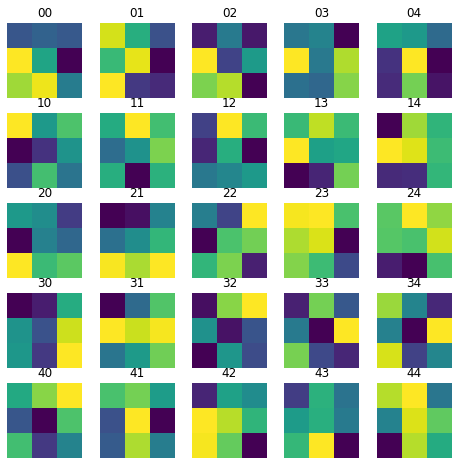

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


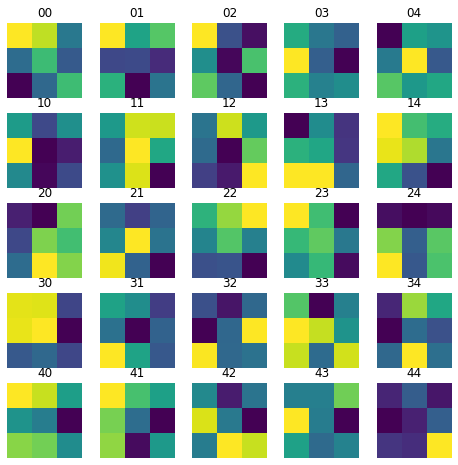

In [ ]:
plot_weights(model,0)
plot_weights(model,2)
plot_weights(model,5)
plot_weights(model,7)
plot_weights(model,10)
plot_weights(model, 12)
